In [28]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [29]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np

In [30]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [31]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [32]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview")
market.disconnect()

In [33]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [34]:
portfolios = PortfolioSelection.generate_possible_portfolios(group_percentages=[0.5])

In [35]:
additional_portfolios = []
for portfolio in portfolios:
    if portfolio.timeframe.value == "week" and portfolio.position_type.label == "long" and portfolio.selection_type.label != "long_short":
        for member in Indicator:
            pm = copy.deepcopy(portfolio)
            pm.ranking_metric = member.label
            additional_portfolios.append(pm)

In [36]:
analysises = []
for rolling_window in [20]:
    market.connect()
    prices = []
    for ticker in tqdm(index["ticker"]): 
        try:
            price = market.query("prices", {"ticker": ticker})
            if price.index.size > 150:
                price = p.lower_column(price)
                price = p.utc_date(price)
                price.sort_values("date", inplace=True)
                price = p.additional_date_columns(price)
                for member in Metric:
                    price = member.calculate(price,timeframe=rolling_window)
                for member in Indicator:
                    price = member.calculate(price,timeframe=rolling_window)
                for member in RiskType:
                    price = member.apply(price)
                prices.append(price.dropna())
        except Exception as e:
            print(str(e))
            continue
    market.disconnect()
    model_end = 2015
    backtest_end = 2025
    simulation = pd.concat(prices)
    simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
    simulation.sort_values("date", inplace=True)
    for portfolio in tqdm(additional_portfolios):
        try:
            trades = portfolio.trades(simulation.copy())
            performance = portfolio.portfolio(trades.copy(),benchmark.copy())
            metrics = KPI.performance(trades,performance)
            results = {**portfolio.to_dict(),**metrics.copy()}
            results["portfolio"] = portfolio
            results["rolling_window"] = rolling_window
            analysises.append(results)
        except Exception as e:
            print(str(e))
            continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [37:35<00:00, 12.53s/it]


In [37]:
a = pd.DataFrame(analysises)

In [38]:
orivault.connect()
orivault.drop("results")
orivault.store("results",a.drop("portfolio",axis=1))
orivault.disconnect()

In [39]:
a[a["selection_type"]!="long_short"].reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,index,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,rolling_window
16,16,sma,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,7857.795634,3.489915,2251.572278,1.109816,0.915397,0.527273,1.017909,3.487586,<financial_common.portfolio_management.portfol...,20
18,18,ema,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,5218.902775,2.444101,2135.305624,1.112077,0.913346,0.524909,1.017662,2.441630,<financial_common.portfolio_management.portfol...,20
21,21,bollinger_upper,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,3574.180285,3.851456,928.007623,1.107332,0.915663,0.536000,1.018398,3.845804,<financial_common.portfolio_management.portfol...,20
39,39,roc,WEEK,long,STANDARD_DEV,bottom,equal,coefficient_of_variation,0.5,1046.602981,3.310698,316.127626,1.103742,0.917178,0.528545,1.015785,3.294107,<financial_common.portfolio_management.portfol...,20
32,32,sma_corr,WEEK,long,STANDARD_DEV,bottom,equal,coefficient_of_variation,0.5,687.545467,2.743947,250.568011,1.097348,0.921367,0.526364,1.013997,2.722889,<financial_common.portfolio_management.portfol...,20
153,153,ema,WEEK,long,SIMPLE_MOVING_AVERAGE,top,equal,coefficient_of_variation,0.5,24.398779,0.215957,112.979776,1.113493,0.907061,0.489636,1.008138,0.169252,<financial_common.portfolio_management.portfol...,20
167,167,sma_corr,WEEK,long,SIMPLE_MOVING_AVERAGE,bottom,equal,coefficient_of_variation,0.5,15.914429,0.560484,28.394105,1.097060,0.915825,0.505273,1.007398,0.374646,<financial_common.portfolio_management.portfol...,20
63,63,ema,WEEK,long,AVERAGE_RETURN,top,equal,coefficient_of_variation,0.5,14.886394,0.990381,15.030980,1.086900,0.916987,0.510182,1.003673,0.639326,<financial_common.portfolio_management.portfol...,20
85,85,williams_r,WEEK,long,AVERAGE_RETURN,bottom,equal,coefficient_of_variation,0.5,12.210927,3.120745,3.912824,1.049354,0.944966,0.579636,1.005473,1.780360,<financial_common.portfolio_management.portfol...,20
2,2,sma_corr,WEEK,long,STANDARD_DEV,mixed,equal,coefficient_of_variation,0.5,10.478557,2.144132,4.887087,1.065627,0.940516,0.516545,1.005142,1.064408,<financial_common.portfolio_management.portfol...,20


In [40]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

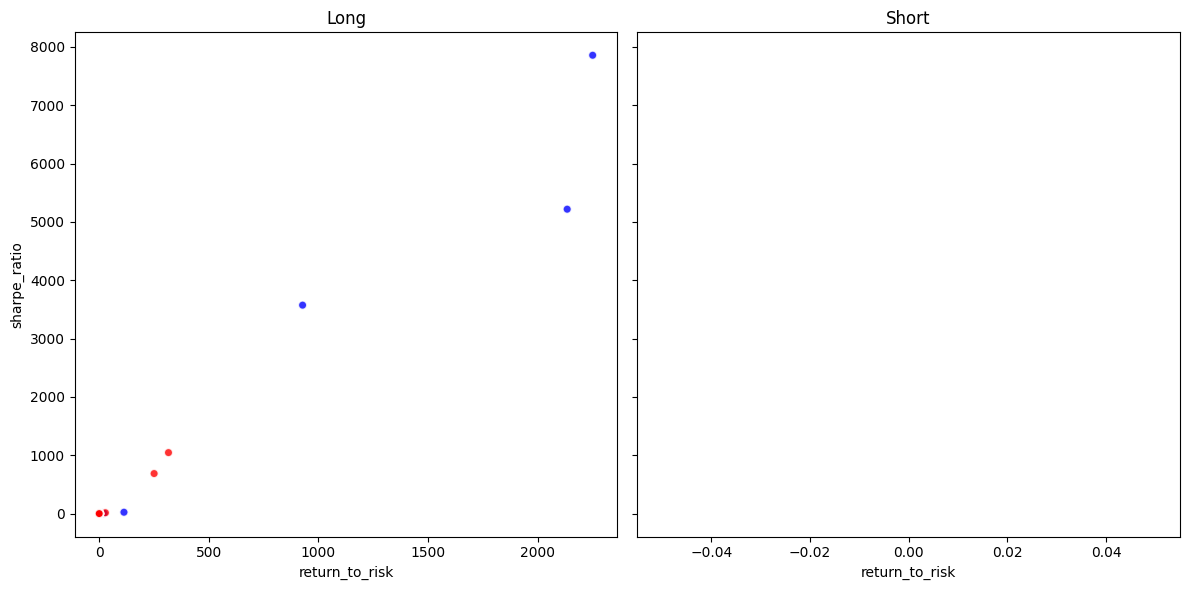

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [42]:
valid = a[(a["position_type"]=="long")].sort_values("pnl",ascending=False).head(20)
valid

,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,date,pnl,...,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,rolling_window,color,return_to_risk
16,sma,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,7857.795634,...,2251.572278,1.109816,0.915397,0.527273,1.017909,3.487586,<financial_common.portfolio_management.portfol...,20,blue,3.489915
18,ema,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,5218.902775,...,2135.305624,1.112077,0.913346,0.524909,1.017662,2.441630,<financial_common.portfolio_management.portfol...,20,blue,2.444101
21,bollinger_upper,WEEK,long,STANDARD_DEV,top,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,3574.180285,...,928.007623,1.107332,0.915663,0.536000,1.018398,3.845804,<financial_common.portfolio_management.portfol...,20,blue,3.851456
39,roc,WEEK,long,STANDARD_DEV,bottom,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,1046.602981,...,316.127626,1.103742,0.917178,0.528545,1.015785,3.294107,<financial_common.portfolio_management.portfol...,20,red,3.310698
32,sma_corr,WEEK,long,STANDARD_DEV,bottom,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,687.545467,...,250.568011,1.097348,0.921367,0.526364,1.013997,2.722889,<financial_common.portfolio_management.portfol...,20,red,2.743947
153,ema,WEEK,long,SIMPLE_MOVING_AVERAGE,top,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,24.398779,...,112.979776,1.113493,0.907061,0.489636,1.008138,0.169252,<financial_common.portfolio_management.portfol...,20,blue,0.215957
167,sma_corr,WEEK,long,SIMPLE_MOVING_AVERAGE,bottom,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,15.914429,...,28.394105,1.097060,0.915825,0.505273,1.007398,0.374646,<financial_common.portfolio_management.portfol...,20,red,0.560484
63,ema,WEEK,long,AVERAGE_RETURN,top,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,14.886394,...,15.030980,1.086900,0.916987,0.510182,1.003673,0.639326,<financial_common.portfolio_management.portfol...,20,blue,0.990381
85,williams_r,WEEK,long,AVERAGE_RETURN,bottom,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,12.210927,...,3.912824,1.049354,0.944966,0.579636,1.005473,1.780360,<financial_common.portfolio_management.portfol...,20,red,3.120745
2,sma_corr,WEEK,long,STANDARD_DEV,mixed,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,10.478557,...,4.887087,1.065627,0.940516,0.516545,1.005142,1.064408,<financial_common.portfolio_management.portfol...,20,green,2.144132


In [48]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Metric:
                price = member.calculate(price,timeframe=20)
            for member in Indicator:
                price = member.calculate(price,timeframe=20)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()
model_end = 2015
backtest_end = 2025
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4266/4266 [04:27<00:00, 15.93it/s]


In [49]:
top = valid[valid["selection_type"]!="long_short"].sort_values("pnl",ascending=False).head(20).to_dict("records")[0]
print(top)
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

{'ranking_metric': 'sma', 'timeframe': 'WEEK', 'position_type': 'long', 'grouping_type': 'STANDARD_DEV', 'selection_type': 'top', 'allocation_type': 'equal', 'risk_type': 'coefficient_of_variation', 'selection_percentage': 0.5, 'date': Timestamp('2024-12-20 00:00:00+0000', tz='UTC'), 'pnl': 7857.795633874551, 'coefficient_of_variation': 3.4899148962897732, 'portfolio_std': 2251.572278231883, 'average_gain': 1.1098160666634587, 'average_loss': 0.9153974301174183, 'win_loss_ratio': 0.5272727272727272, 'weekly_return': 1.0179090748416941, 'sharpe_ratio': 3.487585550159361, 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio object at 0x0000019AD8C02350>, 'rolling_window': 20, 'color': 'blue', 'return_to_risk': 3.4899148962897732}


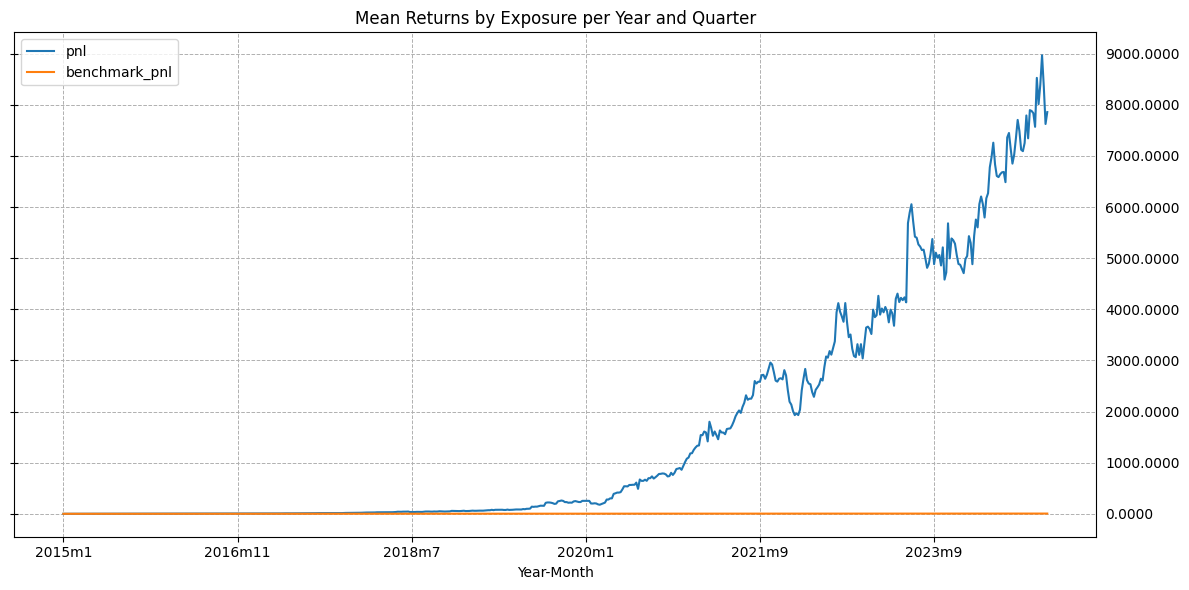

In [50]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio["month"].astype(str)
ax = portfolio[["Year-Month","pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [51]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
KSCP,1.375000
MFA,1.375000
CNTY,1.375000
CZR,1.375000
INBS,1.375000
...,...
IHRT,0.799708
ADTX,0.799708
ACR,0.799708


In [52]:
trades.sort_values("date",ascending=False).dropna().head(20)

,year,week,ticker,date,adjclose,sell_price,standard_dev,sma,risk,group_percentile,rank_percentile,position_type,weight,unweighted_return,winsorized_return,return,month,quarter
major_key,,,,,,,,,,,,,,,,,,
2024_51_0.9,2024,51,AQB,2024-12-20 00:00:00+00:00,0.5801,0.5240,0.126204,1.585490,0.198043,0.9,0.002,1.0,1,0.903293,0.903293,0.903293,12,4
2024_51_0.4,2024,51,ENTA,2024-12-20 00:00:00+00:00,6.3100,6.2800,1.003798,1.409784,0.166169,0.4,0.002,1.0,1,0.995246,0.995246,0.995246,12,4
2024_51_1.0,2024,51,FTFT,2024-12-20 00:00:00+00:00,0.2705,0.3014,0.054107,1.430426,0.135656,1.0,0.005,1.0,1,1.114233,1.114233,1.114233,12,4
2024_51_0.1,2024,51,CRVO,2024-12-20 00:00:00+00:00,1.9500,2.2300,3.368313,4.399079,0.267940,0.1,0.002,1.0,1,1.143590,1.143590,1.143590,12,4
2024_51_0.2,2024,51,APVO,2024-12-20 00:00:00+00:00,3.8800,4.4100,2.062966,2.307977,0.326647,0.2,0.002,1.0,1,1.136598,1.136598,1.136598,12,4
2024_51_0.3,2024,51,RLMD,2024-12-20 00:00:00+00:00,0.3888,0.3629,1.239146,5.246975,0.298785,0.3,0.002,1.0,1,0.933385,0.933385,0.933385,12,4
2024_51_0.0,2024,51,QTTB,2024-12-20 00:00:00+00:00,3.5000,3.5900,8.362040,6.258176,0.267292,0.0,0.005,1.0,1,1.025714,1.025714,1.025714,12,4
2024_51_0.5,2024,51,PBM,2024-12-20 00:00:00+00:00,1.8500,3.1800,0.729945,1.618784,0.951031,0.5,0.002,1.0,1,1.375000,1.375000,1.375000,12,4
2024_51_0.6,2024,51,CLRB,2024-12-20 00:00:00+00:00,0.2577,0.2350,0.477635,5.157538,0.211915,0.6,0.002,1.0,1,0.911913,0.911913,0.911913,12,4
